# Forecasting Dublin Bike Availability Using Machine Learning Models



## CA3 Capstone Project Strategic Thinking
### Eliana Hincapie

The primary objective of this project is to develop machine learning models capable of accurately forecasting the availability of bicycles at individual Dublin Bikes stations. 

In [1]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings 

warnings.filterwarnings('ignore')

In [3]:
#Load dataset
df = pd.read_csv('dublin-bikes_station_status_122024.csv')

#### Understanding the Data

In [4]:
#Preview data
df.head()

,system_id,last_reported,station_id,num_bikes_available,num_docks_available,is_installed,is_renting,is_returning,name,short_name,address,lat,lon,region_id,capacity
0,dublin_bikes,2024-12-01 00:05:00,1,22,9,True,True,True,CLARENDON ROW,NaN,Clarendon Row,53.340927,-6.262501,NaN,31
1,dublin_bikes,2024-12-01 00:05:00,101,10,20,True,True,True,KING STREET NORTH,NaN,King Street North,53.350292,-6.273507,NaN,30
2,dublin_bikes,2024-12-01 00:05:00,102,2,38,True,True,True,WESTERN WAY,NaN,Western Way,53.354930,-6.269425,NaN,40
3,dublin_bikes,2024-12-01 00:05:00,103,0,40,True,True,True,GRANGEGORMAN LOWER (SOUTH),NaN,Grangegorman Lower (South),53.354664,-6.278681,NaN,40
4,dublin_bikes,2024-12-01 00:05:00,104,0,40,True,True,True,GRANGEGORMAN LOWER (CENTRAL),NaN,Grangegorman Lower (Central),53.355170,-6.278424,NaN,40


In [5]:
#Basic info and shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 605009 entries, 0 to 605008
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   system_id            605009 non-null  object 
 1   last_reported        605009 non-null  object 
 2   station_id           605009 non-null  int64  
 3   num_bikes_available  605009 non-null  int64  
 4   num_docks_available  605009 non-null  int64  
 5   is_installed         605009 non-null  bool   
 6   is_renting           605009 non-null  bool   
 7   is_returning         605009 non-null  bool   
 8   name                 605009 non-null  object 
 9   short_name           0 non-null       float64
 10  address              605009 non-null  object 
 11  lat                  605009 non-null  float64
 12  lon                  605009 non-null  float64
 13  region_id            0 non-null       float64
 14  capacity             605009 non-null  int64  
dtypes: bool(3), float

In [6]:
df.shape

(605009, 15)

In [7]:
#Descriptive statistics (numerical)
df.describe()

,station_id,num_bikes_available,num_docks_available,short_name,lat,lon,region_id,capacity
count,605009.000000,605009.000000,605009.00000,0.0,605009.000000,605009.000000,0.0,605009.000000
mean,57.951001,12.308017,19.21137,NaN,53.345457,-6.263820,NaN,31.964569
std,33.974053,9.713911,10.91414,NaN,0.007517,0.017848,NaN,7.441581
min,1.000000,0.000000,0.00000,NaN,53.330090,-6.310015,NaN,16.000000
25%,28.000000,4.000000,11.00000,NaN,53.339764,-6.275071,NaN,29.000000
50%,58.000000,11.000000,19.00000,NaN,53.344604,-6.262501,NaN,30.000000
75%,88.000000,19.000000,27.00000,NaN,53.350292,-6.250900,NaN,40.000000
max,117.000000,40.000000,40.00000,NaN,53.359966,-6.230852,NaN,40.000000


In [8]:
#Missing values
df.isnull().sum()

system_id                   0
last_reported               0
station_id                  0
num_bikes_available         0
num_docks_available         0
is_installed                0
is_renting                  0
is_returning                0
name                        0
short_name             605009
address                     0
lat                         0
lon                         0
region_id              605009
capacity                    0
dtype: int64

In [9]:
#Duplicates
df.duplicated().sum()

0

In [10]:
#Group by station and get the maximum capacity (bike_stands)
station_capacity = df.groupby('station_id')['capacity'].max().reset_index()
station_capacity

,station_id,capacity
0,1,31
1,2,20
2,3,20
3,4,20
4,5,40
...,...,...
110,113,40
111,114,40
112,115,30
113,116,30


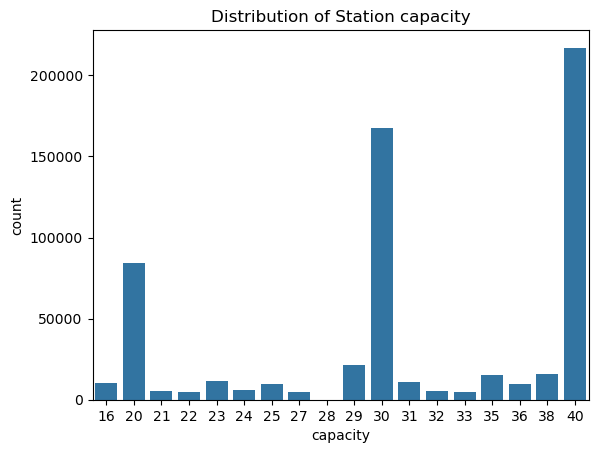

In [11]:
sns.countplot(data=df, x='capacity')
plt.title('Distribution of Station capacity')
plt.show()

#### Data Preparation

The missing values are in the 'short_name' and 'region_id' columns, we are going to drop both columns taking into account that null values are 100% for both columns and were not critical for forecasting bike availability.

In [12]:
#Drop specific columns
df = df.drop(columns=['short_name', 'region_id'])

In [13]:
#Confirm Missing values
df.isnull().sum()

system_id              0
last_reported          0
station_id             0
num_bikes_available    0
num_docks_available    0
is_installed           0
is_renting             0
is_returning           0
name                   0
address                0
lat                    0
lon                    0
capacity               0
dtype: int64

With the preview of the data in the understanding process, we can see that can be some attributes that have the same data, which are: system_id, is_installed, is_renting and is_returning.
We are going to check it to define if them are or not useful in our dataset.

In [14]:
df['system_id'].unique()

array(['dublin_bikes'], dtype=object)

In [15]:
df['is_installed'].unique()

array([ True])

In [16]:
df['is_renting'].unique()

array([ True])

In [17]:
df['is_returning'].unique()

array([ True])

Taking into consideration that this attributes have the same value and there are not an important input for our forecast, we are going to drop them all.

In [18]:
#Drop columns
df = df.drop(columns=['system_id', 'is_installed', 'is_renting', 'is_returning'])

In [19]:
#Preview data
df.head()

,last_reported,station_id,num_bikes_available,num_docks_available,name,address,lat,lon,capacity
0,2024-12-01 00:05:00,1,22,9,CLARENDON ROW,Clarendon Row,53.340927,-6.262501,31
1,2024-12-01 00:05:00,101,10,20,KING STREET NORTH,King Street North,53.350292,-6.273507,30
2,2024-12-01 00:05:00,102,2,38,WESTERN WAY,Western Way,53.354930,-6.269425,40
3,2024-12-01 00:05:00,103,0,40,GRANGEGORMAN LOWER (SOUTH),Grangegorman Lower (South),53.354664,-6.278681,40
4,2024-12-01 00:05:00,104,0,40,GRANGEGORMAN LOWER (CENTRAL),Grangegorman Lower (Central),53.355170,-6.278424,40


In [20]:
df.shape

(605009, 9)

In [21]:
#Convert last_reported to datetime
df['last_reported'] = pd.to_datetime(df['last_reported'])

In [22]:
#Confirm change, Basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 605009 entries, 0 to 605008
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   last_reported        605009 non-null  datetime64[ns]
 1   station_id           605009 non-null  int64         
 2   num_bikes_available  605009 non-null  int64         
 3   num_docks_available  605009 non-null  int64         
 4   name                 605009 non-null  object        
 5   address              605009 non-null  object        
 6   lat                  605009 non-null  float64       
 7   lon                  605009 non-null  float64       
 8   capacity             605009 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(4), object(2)
memory usage: 41.5+ MB


In [23]:
#Extract time-based features
df['hour'] = df['last_reported'].dt.hour
df['minute'] = df['last_reported'].dt.minute
df['day_of_week'] = df['last_reported'].dt.dayofweek
df['month'] = df['last_reported'].dt.month
df['year'] = df['last_reported'].dt.year
df['date'] = df['last_reported'].dt.date 

In [24]:
#Combine the time 'hour', 'minute' as a string
df['time_str'] = df['last_reported'].dt.strftime('%H:%M')

In [25]:
#Preview data
df.head()

,last_reported,station_id,num_bikes_available,num_docks_available,name,address,lat,lon,capacity,hour,minute,day_of_week,month,year,date,time_str
0,2024-12-01 00:05:00,1,22,9,CLARENDON ROW,Clarendon Row,53.340927,-6.262501,31,0,5,6,12,2024,2024-12-01,00:05
1,2024-12-01 00:05:00,101,10,20,KING STREET NORTH,King Street North,53.350292,-6.273507,30,0,5,6,12,2024,2024-12-01,00:05
2,2024-12-01 00:05:00,102,2,38,WESTERN WAY,Western Way,53.354930,-6.269425,40,0,5,6,12,2024,2024-12-01,00:05
3,2024-12-01 00:05:00,103,0,40,GRANGEGORMAN LOWER (SOUTH),Grangegorman Lower (South),53.354664,-6.278681,40,0,5,6,12,2024,2024-12-01,00:05
4,2024-12-01 00:05:00,104,0,40,GRANGEGORMAN LOWER (CENTRAL),Grangegorman Lower (Central),53.355170,-6.278424,40,0,5,6,12,2024,2024-12-01,00:05


In [26]:
#Convert 'date' and 'time_str' to datetime
df['date'] = pd.to_datetime(df['date'])

In [27]:
df['time_str'] = pd.to_datetime(df['time_str'])

In [28]:
#Confirm change, Basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 605009 entries, 0 to 605008
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   last_reported        605009 non-null  datetime64[ns]
 1   station_id           605009 non-null  int64         
 2   num_bikes_available  605009 non-null  int64         
 3   num_docks_available  605009 non-null  int64         
 4   name                 605009 non-null  object        
 5   address              605009 non-null  object        
 6   lat                  605009 non-null  float64       
 7   lon                  605009 non-null  float64       
 8   capacity             605009 non-null  int64         
 9   hour                 605009 non-null  int32         
 10  minute               605009 non-null  int32         
 11  day_of_week          605009 non-null  int32         
 12  month                605009 non-null  int32         
 13  year          

In [50]:
#Encode station id
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
onehot = encoder.fit_transform(df['station_id'])

ValueError: Expected a 2-dimensional container but got <class 'pandas.core.series.Series'> instead. Pass a DataFrame containing a single row (i.e. single sample) or a single column (i.e. single feature) instead.

In [33]:
df['name'].nunique()

115

In [34]:
df['name_encoded'].nunique()

115

In [38]:
# Final check
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 605009 entries, 0 to 605008
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   last_reported        605009 non-null  datetime64[ns]
 1   station_id           605009 non-null  int64         
 2   num_bikes_available  605009 non-null  int64         
 3   num_docks_available  605009 non-null  int64         
 4   name                 605009 non-null  object        
 5   address              605009 non-null  object        
 6   lat                  605009 non-null  float64       
 7   lon                  605009 non-null  float64       
 8   capacity             605009 non-null  int64         
 9   hour                 605009 non-null  int32         
 10  minute               605009 non-null  int32         
 11  day_of_week          605009 non-null  int32         
 12  month                605009 non-null  int32         
 13  year          

,last_reported,station_id,num_bikes_available,num_docks_available,name,address,lat,lon,capacity,hour,minute,day_of_week,month,year,date,time_str,name_encoded
0,2024-12-01 00:05:00,1,22,9,CLARENDON ROW,Clarendon Row,53.340927,-6.262501,31,0,5,6,12,2024,2024-12-01,2025-05-09 00:05:00,14
1,2024-12-01 00:05:00,101,10,20,KING STREET NORTH,King Street North,53.350292,-6.273507,30,0,5,6,12,2024,2024-12-01,2025-05-09 00:05:00,67
2,2024-12-01 00:05:00,102,2,38,WESTERN WAY,Western Way,53.354930,-6.269425,40,0,5,6,12,2024,2024-12-01,2025-05-09 00:05:00,109
3,2024-12-01 00:05:00,103,0,40,GRANGEGORMAN LOWER (SOUTH),Grangegorman Lower (South),53.354664,-6.278681,40,0,5,6,12,2024,2024-12-01,2025-05-09 00:05:00,41
4,2024-12-01 00:05:00,104,0,40,GRANGEGORMAN LOWER (CENTRAL),Grangegorman Lower (Central),53.355170,-6.278424,40,0,5,6,12,2024,2024-12-01,2025-05-09 00:05:00,39
